# Loading Packages & Initialization

reference : https://gist.github.com/mertedali/ab7078b9c29dea18c72525239d636b96

In [2]:
rm(list=ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs) # For maximin Latin hypercube sampling
library(ggplot2)
library(plotly) # For beautiful plotting
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr) # for evaluating predictive power

require(gridExtra)

options(warn = -1)

In [3]:
# Select if data generation is wanted
GenerateTTData <- 0

In [4]:
Is_Headless <- 1
nl.model <- "Segregation_OneShot"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
model.path <- paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/",nl.model,".nlogo")


if (Is_Headless == 0){
    NLStart(nl.path, gui = TRUE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    } else {
    NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar', nl.obj = nl.model)
    NLLoadModel (model.path, nl.obj = nl.model)
    
    #NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar', nl.obj = nl.model)
    #NLLoadModel (model.path, nl.obj = nl.model )
    }

# Model Parameters & Functions

## Set model parameters

In [5]:
## Set model parameters
 # Number of replications for each instance
nofrep = 3   

# Number of iterations
iteration_budget = 21
 # order feature names according to their definition order in run_model
feature_names = c("density","%-similar-wanted")  
 # 
output_name = c("percent-similar")

 # Number of input parameters of the agent-based model
nofparams = length(feature_names)      

# set RF parameters
ntree = 120
mtry = 2

## Set user parameters

In [6]:
error_type = "RMSE" # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "sd" #, "range" 

unlabeled_ins = 700 
test_ins = 400
train_ins_oneshot = 700
train_ins_Ad = 200

# Set selection parameters
selected_ins = 25 #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1 # number of variables eliminated in each step


## Define functions

### run_model

In [7]:
#run_model <- function(feature_names,feature_values){ # both should be in character list format
run_model <- function(feature_values){ # both should be in character list format

    
    k = length(feature_names)    
    for(i in 1:k){
        NLCommand(paste0("set ",feature_names[i]," ",feature_values[i]), nl.obj = nl.model)      
    }
    NLCommand("setup", nl.obj = nl.model)
    NLDoCommand(100, "go", nl.obj = nl.model) 
    result <- NLReport(output_name, nl.obj = nl.model)
    return(result)   
}

### run_replicas

In [8]:
#run_replicas <- function(nofrep,feature_names,feature_values) {
run_replicas <- function(nofrep,feature_values) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1) # Save the result of each replication
    for(i in 1:nofrep){
     #   replicas[i]= run_model(feature_names,feature_values)
        replicas[i]= run_model(feature_values)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}

### run_ABM

In [9]:
#run_ABM = function(nofrep,nofinstances,unlabeledset,featurenames = feature_names){
run_ABM = function(nofrep,nofinstances,unlabeledset){
   #unlabeledset = setcolorder(unlabeledset,featurenames) 
   unlabeledset = setcolorder(unlabeledset,feature_names) 
   for(i in 1:nofinstances){
        #unlabeledset[i, output :=  run_replicas(nofrep,featurenames, as.matrix(unlabeledset[i,]))]    
        unlabeledset[i, output :=  run_replicas(nofrep, as.matrix(unlabeledset[i,]))] 
    } 
    return(unlabeledset)
}


### error functions

In [10]:
#error functions on test data
rmse_func <- function(actual, predicted){
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual,predicted){
    return( (abs(actual - predicted)/ actual)*100 )
}

bias_func <- function(actual,predicted){
    return( (actual - predicted)/ actual )
}

#error functions on train data
obb_error_func <- function(model){
   if(model$type == "regression"){
        oob_error = model$mse[model$ntree] 
    }else if(model$type == "classification"){
        oob_error = model$err.rate 
    } 
    return(oob_error)
}


### get_test_predictions

In [11]:
# prediction functions
get_test_predictions <- function(model,testset,errortype){
    
    predictedLabels <- predict(model, testset)
    predictedLabels <- cbind(testset,predictedLabels)
    setnames(predictedLabels, "predictedLabels","pred_output")

    output_variables = colnames(select(predictedLabels, contains("output")))
    # output_variables[1] = true output
    # output_variables[2] = predicted output
    
    #output_variables = colnames(predictedLabels[,1:(ncol(predictedLabels) - 2)])
    
    if(error_type == "MAPE"){
        predictedLabels[,MAPE := mapply(function(x,y) mape_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "RMSE"){
        predictedLabels[,RMSE := mapply(function(x,y) rmse_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "BIAS"){
        predictedLabels[,BIAS := mapply(function(x,y) bias_func(x,y),get(output_variables[1]),get(output_variables[2]))]
           } 
                                  
     output_variables_1 = predictedLabels[,get(output_variables[1]), with = TRUE]
     output_variables_2 = predictedLabels[,get(output_variables[2]), with = TRUE]
    
     performance_temp = matrix(c(1:3), nrow = 1, ncol = 3)
     performance_temp[1] =  mae(output_variables_1 , output_variables_2)
     performance_temp[2] = rmse(output_variables_1 , output_variables_2)
     performance_temp[3] = mape(output_variables_1 , output_variables_2)
    
    return(list(predictedLabels,performance_temp,output_variables))
    
} 

### sample_selection

In [12]:
# Adaptive sample selection function with an uncertainty measure depending on "selection_metric"
sample_selection <- function(selected_ins,unlabeled_set,model){   
    ind_pred <- t(predict(model, unlabeled_set,predict.all = TRUE)$individual) %>% 
                data.table() # predictions by each tree in the forest
    ind_pred_eval = data.table()
    
    # standard deviation calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev,".","sd")
    ind_pred_eval = cbind(ind_pred_eval,s_dev)
    
    # range calculation
    range = sapply(ind_pred, range) %>% t() %>% data.table()
    range = range[,.(range = abs(range[,1] - range[,2]))]
    setnames(range,"range.V1","range")
    ind_pred_eval = cbind(ind_pred_eval,range)
    
    ind_pred_eval[,idx := 1:.N]
    
    if(selection_metric == "sd") {
      ind_pred_eval = ind_pred_eval[order(-sd)][1:selected_ins]
    }else if(selection_metric == "range"){
      ind_pred_eval = ind_pred_eval[order(-range)][1:selected_ins]
    }
    
    unlabeled_set[,idx := 1:.N]    
    train_candidates = unlabeled_set[ind_pred_eval$idx]
    
    return(train_candidates)
}


### random_sample_selection

In [13]:
# Random sample selection
random_sample_selection <- function(selected_ins,unlabeled_set){
  
    unlabeled_set[,idx := 1:.N]
    
    train_candidate_idx = sample(unlabeled_set$idx, selected_ins, replace = FALSE, prob = NULL)   
    train_candidates = unlabeled_set[idx %in% train_candidate_idx]
    
    return(train_candidates)
}

### get_variable_importance

In [14]:
get_variable_importance <- function(model){
    importances <- importance(model, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ranked_features = feature_names[selected.vars]
    ordered.importances <- importances[selected.vars]
    
    return(ranked_features)
}                      

### feature_elimination

In [15]:
feature_elimination <- function(h,total_numof_eliminated_vars,ranked_features){ 
    numof_columns_left = length(ranked_features) - (total_numof_eliminated_vars + h)
    columns_left = ranked_features[1:numof_columns_left]
    
    eliminated_columns = setdiff((length(ranked_features) - total_numof_eliminated_vars), numof_columns_left)
    eliminated_columns = ranked_features[eliminated_columns]
    
    # update total_numof_eliminated_vars
    total_numof_eliminated_vars = length(ranked_features) - length(columns_left)
    
    return(list(columns_left,total_numof_eliminated_vars,h,eliminated_columns))
 }

# Generate Unlabeled Data Pool

## Latin hyper cube sampling

In [16]:
if(GenerateTTData == 1){
    unlabeled_pool = as.data.table(maximinLHS(n = unlabeled_ins, k = nofparams, dup = 5))
    
    unlabeled_pool$V1 = qunif(unlabeled_pool$V1, 10, 90) 
    unlabeled_pool$V2 = qunif(unlabeled_pool$V2, 10, 90) 
    setnames(unlabeled_pool, c(paste0("V",1:nofparams)), feature_names)
    
    unlabeled_pool[,idx := 1:.N]
        
    fwrite(unlabeled_pool, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_",Sys.Date(),".csv"))
}else{
    unlabeled_pool <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_04122019.csv")   
    unlabeled_pool <- head(unlabeled_pool[`%-similar-wanted` < 90 & `density` < 90],700) 
}

In [17]:
data_candidates =copy(unlabeled_pool)

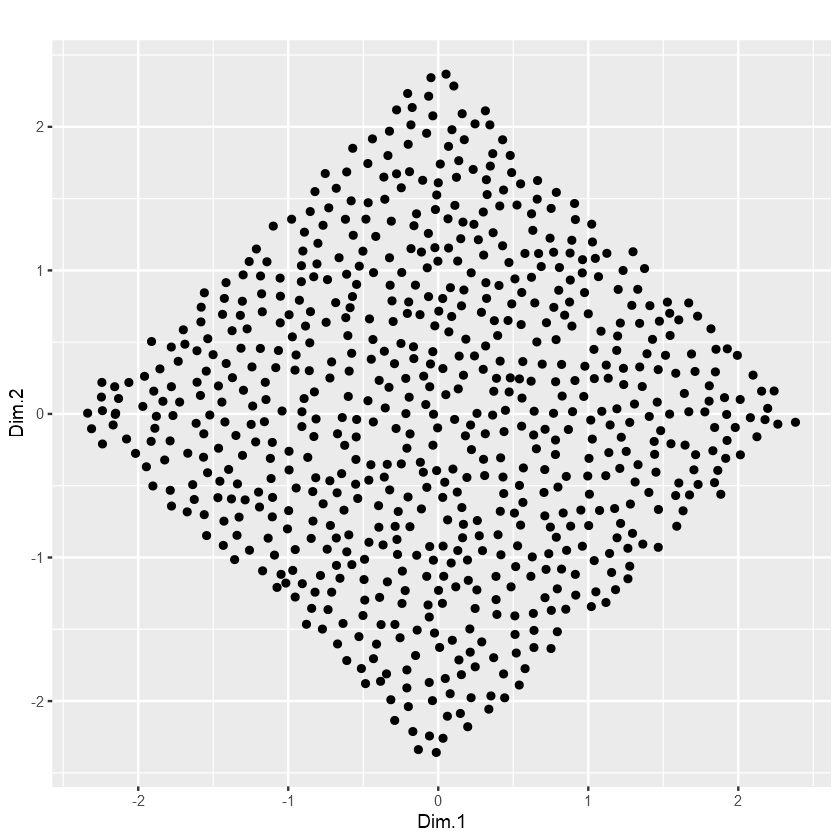

In [18]:
pca_unlabeled_pool <- princomp(unlabeled_pool[,-c("idx")], cor = TRUE, scores = TRUE)
pca_unlabeled_pool_components <- get_pca_ind(pca_unlabeled_pool)
p_unlabeled_pool <- ggplot(data = data.table(pca_unlabeled_pool_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_unlabeled_pool


# Generate Test Set

In [19]:
if(GenerateTTData == 1){
    test_set <- head(unlabeled_pool,test_ins)
    ################## Buraya variale'ların datatipine göre bir şeyler yazılabilir
    test_set$density            = runif(test_ins, 10, 90) 
    test_set$`%-similar-wanted` = runif(test_ins, 10, 90) 
    test_set[,c("idx"):= NULL]
       
    print(paste0("ABM run start time : ",Sys.time()))
    test_set = run_ABM(nofrep,test_ins,test_set) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(test_set, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_",Sys.Date(),".csv"))
}else{
    test_set <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_04122019.csv")  
    #below part is only for this .csv
    test_set <- head(test_set[`%-similar-wanted` < 90],800) 
    
    test_set[,idx := 1:.N]    
    test_set_idx = sample(test_set$idx, test_ins, replace = FALSE, prob = NULL)   
    test_set = test_set[idx %in% test_set_idx]
    test_set[,idx:= NULL]
}

10 * 10 ~ 1 min
100 * 10 ~ 14 min
900 * 10 ~ 09:16 -- 2019-12-03 07:54:10 +03"

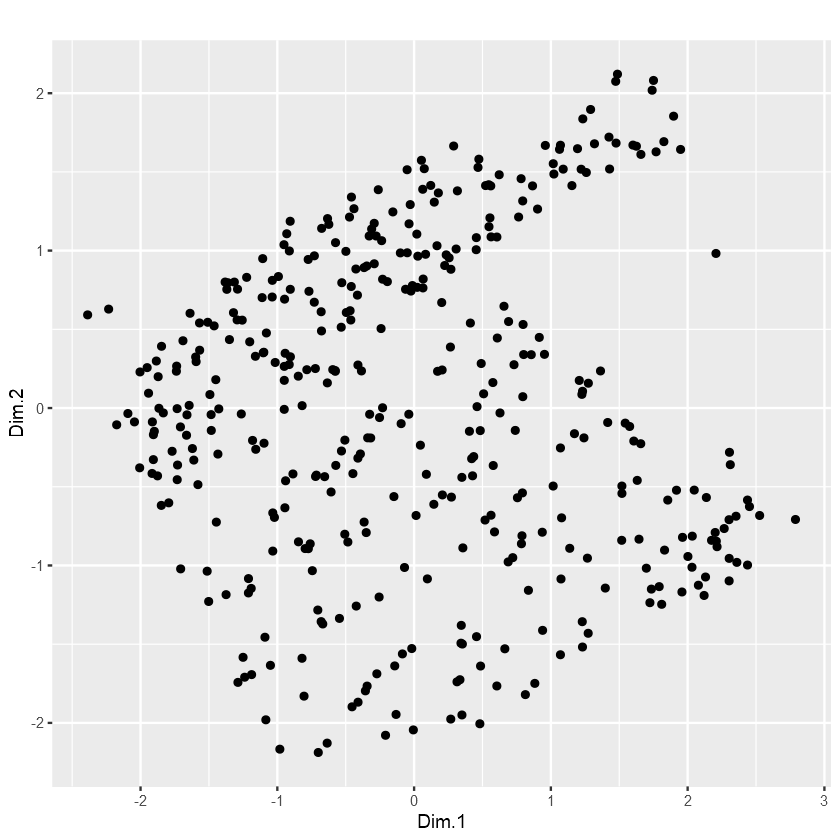

In [20]:
pca_test_set <- princomp(test_set, cor = TRUE, scores = TRUE)
pca_test_set_components <- get_pca_ind(pca_test_set)
p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_test_set

# Benchmark : One-shot sampling, No feature elimination

## Generate Training Set

Select a very big data pool ( nofinstances should be very high ) , like 1000

In [21]:
if(GenerateTTData == 1){
    training_set = as.data.table(maximinLHS(n = train_ins_oneshot, k = nofparams, dup = 5))
    
    training_set$V1 = qunif(training_set$V1, 10, 90) 
    training_set$V2 = qunif(training_set$V2, 10, 90) 
    setnames(training_set, c(paste0("V",1:nofparams)), feature_names)
    
    training_set$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    training_set = run_ABM(nofrep,train_ins_oneshot,LHSample) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))  
    
    fwrite(training_set, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/training_set_",Sys.Date(),".csv"))
    
}else{
    training_set <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_04122019.csv")
    training_set <- head(training_set[`%-similar-wanted` < 90],700)
}

In [22]:
one_shot_data = copy(training_set)

### Visualization

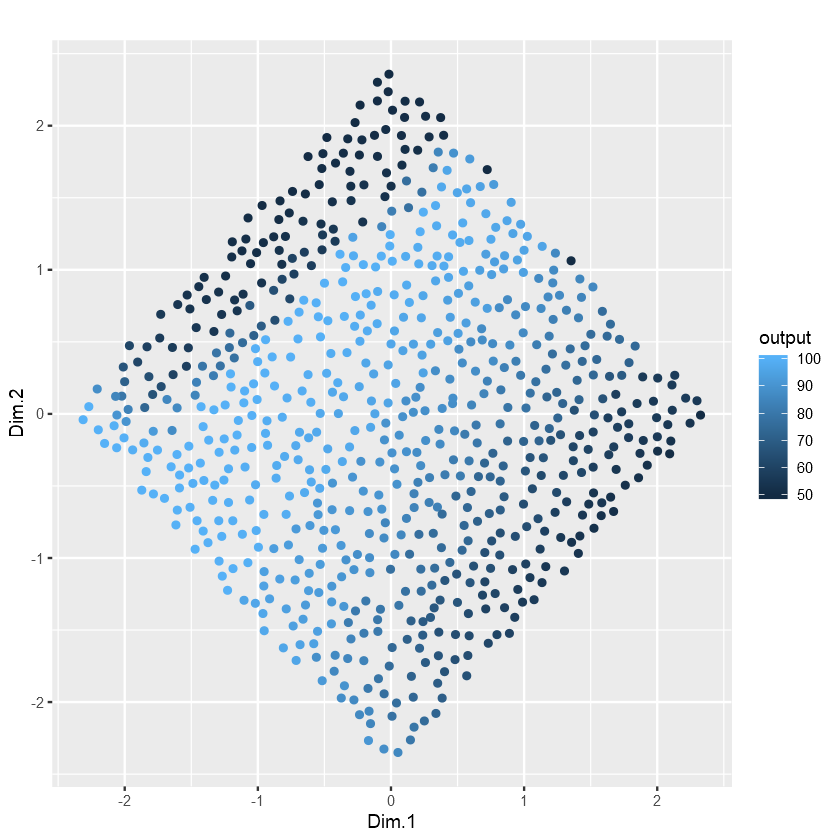

In [23]:
pca_training_set <- princomp(training_set[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

pca_training_set_components <- get_pca_ind(pca_training_set)
pca_training_set_components <-cbind(pca_training_set_components$coord[,1:2],training_set[,.SD, .SDcols = c("output")])
p_training_set <- ggplot(data = pca_training_set_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_training_set

## Train & Test Metamodel

In [24]:
model_oneshot <- randomForest(x = training_set[, -c("output")], y = training_set$output, importance = TRUE,ntree = ntree, mtry = mtry)
model_oneshot


Call:
 randomForest(x = training_set[, -c("output")], y = training_set$output,      ntree = ntree, mtry = mtry, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 120
No. of variables tried at each split: 2

          Mean of squared residuals: 9.849142
                    % Var explained: 96.73

In [25]:
obb_error_oneshot <- obb_error_func(model_oneshot)

In [ ]:
#OBB_pred = cbind(training_set$output,model_oneshot$predicted)
#names(OBB_pred) <- c("actual","predicted")

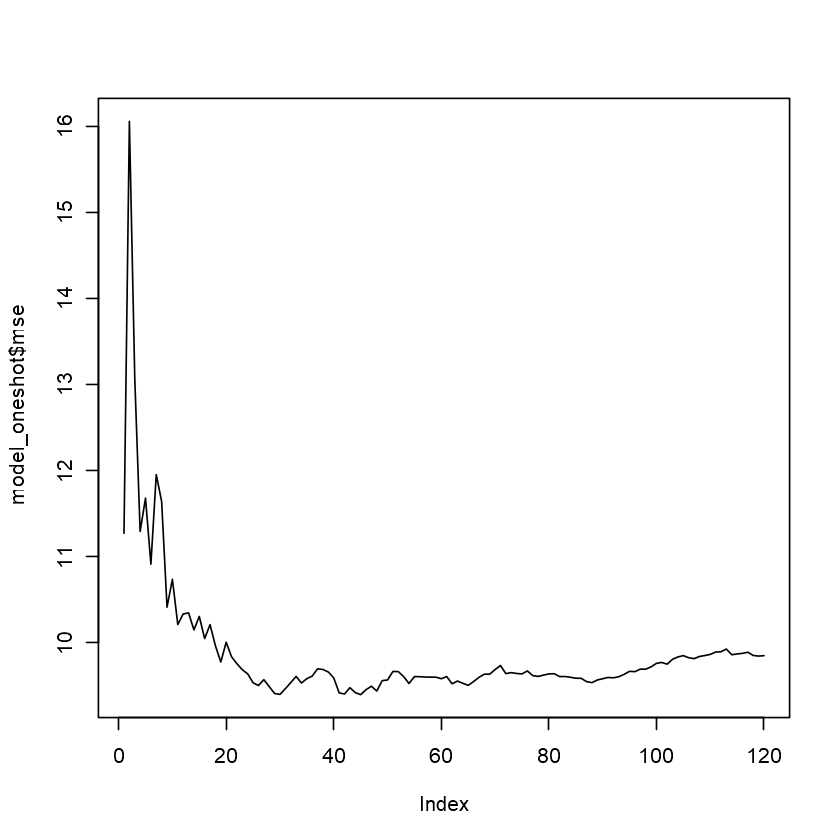

In [26]:
plot(model_oneshot$mse, type="l")

In [27]:
test_prediction_oneshot = get_test_predictions(model_oneshot,test_set,error_type)
predictedLabels_oneshot = test_prediction_oneshot[[1]]

performance_table_oneshot = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())
# Keep test set error records
performance_table_oneshot = rbind(performance_table_oneshot, data.table(1, test_prediction_oneshot[[2]]), use.names = FALSE)

output_variables = test_prediction_oneshot[[3]]    


In [28]:
performance_table_oneshot
obb_error_oneshot
head(predictedLabels_oneshot)

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,0.8717707,2.257466,1.274766


[1] 9.849142

density,%-similar-wanted,output,pred_output,RMSE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39.27182,36.46039,86.97693,86.36555,0.6113720
28.12210,68.05564,99.86504,99.86214,0.0029045
75.80979,17.80044,57.77487,57.92010,0.1452339
57.76825,28.64345,73.81257,73.00245,0.8101162
18.53175,48.03778,93.79242,94.10447,0.3120526
80.09701,42.18455,82.70191,83.74711,1.0451976


In [29]:
performance_molten_oneshot <- melt(data = performance_table_oneshot
                             , id.vars = 'iter')
setnames(performance_molten_oneshot, c("variable","value"),c("errortype","errorvalue"))

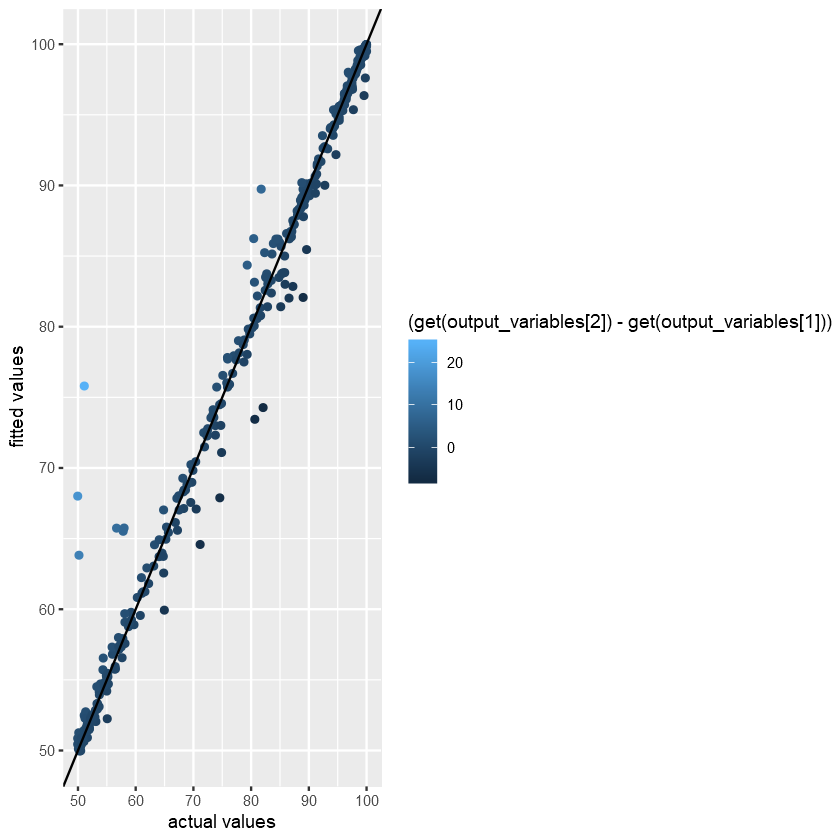

In [30]:
p_oneshot <- ggplot(predictedLabels_oneshot,aes(x = get(output_variables[1]), y = get(output_variables[2]), color = (get(output_variables[2]) - get(output_variables[1])))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values")

p_oneshot

# Random Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [31]:
if(GenerateTTData == 1){
   
    training_set_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
    
    training_set_Ad$V1 = qunif(training_set_Ad$V1, 10, 90) 
    training_set_Ad$V2 = qunif(training_set_Ad$V2, 10, 90) 
    setnames(training_set_Ad, c(paste0("V",1:nofparams)), feature_names)
    training_set_Ad$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    training_set_Ad = run_ABM(nofrep,train_ins_Ad,training_set_Ad) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(training_set_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))

}else{
    training_set_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
    training_set_Ad <- head(training_set_Ad[`%-similar-wanted` < 90  & `density` < 90],200)

}

In [32]:
adaptive_initial_data = copy(training_set_Ad)

## Visualization

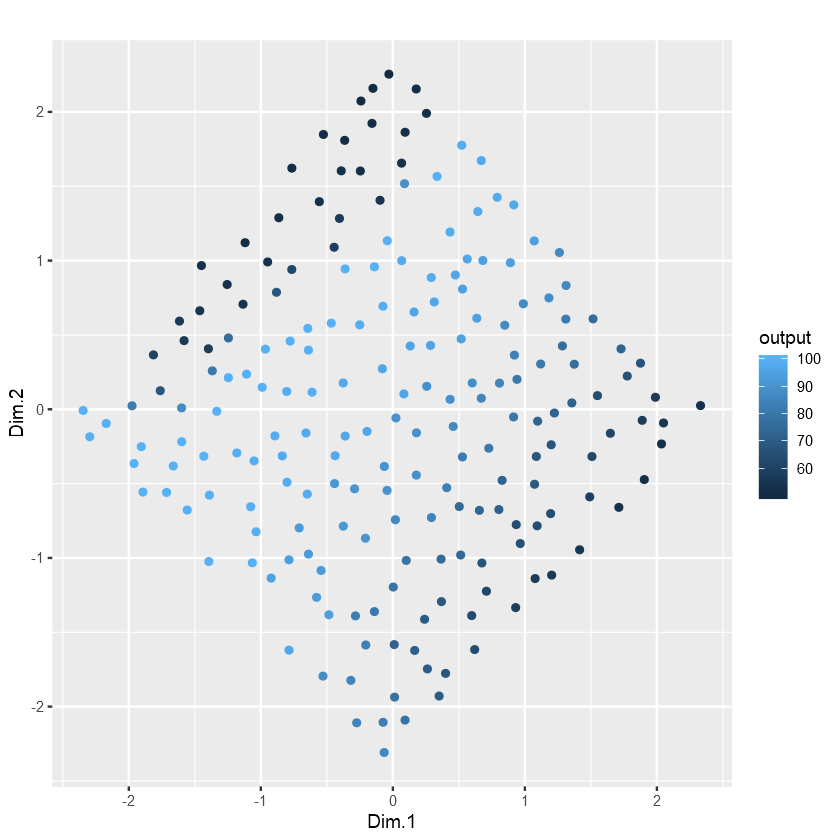

In [33]:
pca_training_set_Ad <- princomp(adaptive_initial_data[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

pca_training_set_Ad_components <- get_pca_ind(pca_training_set_Ad)
pca_training_set_Ad_components <-cbind(pca_training_set_Ad_components$coord[,1:2],adaptive_initial_data[,.SD, .SDcols = c("output")])
p_training_set_Ad <- ggplot(data = pca_training_set_Ad_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_training_set_Ad

## Train & Test Metamodel

In [34]:
# Decide on strategy:
#iteration_budget = 3   #specified above

## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

In [35]:
set.seed(10)
print(paste0("section start time : ",Sys.time()))
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
                     
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)
    
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)    

    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.
        
    ## sample selection from unlabeled data select candidates
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = random_sample_selection(selected_ins,unlabeled_set)
        
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # run ABM to find outputs of train candidates
    print(paste0("ABM train_candidate run start time : ",Sys.time()))
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    print(paste0("ABM train_candidate run end time : ",Sys.time()))
    
    train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))

    # Add new data to train data
    training_set_Ad = rbind(training_set_Ad,train_candidates[,-c("idx")])
    }
    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!
print(paste0("section end time : ",Sys.time()))

[1] "section start time : 2020-01-09 07:31:59"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-09 07:31:59"
[1] "ABM train_candidate run end time : 2020-01-09 07:32:42"
[1] 2
[1] "ABM train_candidate run start time : 2020-01-09 07:32:42"
[1] "ABM train_candidate run end time : 2020-01-09 07:33:21"
[1] 3
[1] "ABM train_candidate run start time : 2020-01-09 07:33:21"
[1] "ABM train_candidate run end time : 2020-01-09 07:34:06"
[1] 4
[1] "ABM train_candidate run start time : 2020-01-09 07:34:06"
[1] "ABM train_candidate run end time : 2020-01-09 07:34:41"
[1] 5
[1] "ABM train_candidate run start time : 2020-01-09 07:34:41"
[1] "ABM train_candidate run end time : 2020-01-09 07:35:31"
[1] 6
[1] "ABM train_candidate run start time : 2020-01-09 07:35:31"
[1] "ABM train_candidate run end time : 2020-01-09 07:36:04"
[1] 7
[1] "ABM train_candidate run start time : 2020-01-09 07:36:04"
[1] "ABM train_candidate run end time : 2020-01-09 07:36:37"
[1] 8
[1] "ABM train_candidate run start ti

started : 2020-01-09 07:31:59 // ended : 2020-01-09 07:47:18 // 3 nofrep * 25 sample * 20 selection iter = 1500 runs

In [36]:
# Final records
FinalTrainData_Rd = copy(training_set_Ad)
performance_table_Rd = copy(performance_table)
train_candidates_table_Rd  = copy(train_candidates_table)
predictedLabels_table_Rd = copy(predictedLabels_table)
obb_error_Rd = copy(obb_error)

In [37]:
#fwrite(FinalTrainData_Rd,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/FinalTrainData_Rd_BasicCode_OneShot_120tree_",Sys.Date(),".csv") )
#fwrite(performance_table_Rd,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/performance_table_Rd_BasicCode_OneShot_120tree_",Sys.Date(),".csv") )
#fwrite(train_candidates_table_Rd,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/train_candidates_table_Rd_BasicCode_OneShot_120tree_",Sys.Date(),".csv") )
#fwrite(predictedLabels_table_Rd,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/predictedLabels_table_Rdd_BasicCode_OneShot_120tree_",Sys.Date(),".csv") )
#fwrite(obb_error_Rd,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/obb_error_Rd_BasicCode_OneShot_120tree_",Sys.Date(),".csv") )

In [38]:
# show results
nrow(FinalTrainData_Rd)
performance_table_Rd 
train_candidates_table_Rd  
head(predictedLabels_table_Rd)
obb_error_Rd

[1] 700

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,2.098431,4.726630,3.057153
2,1.981412,4.570033,2.873256
3,1.761173,4.212072,2.544558
4,1.708033,4.209987,2.490380
5,1.650386,4.095514,2.394935
6,1.690283,4.275809,2.485206
7,1.577566,4.153829,2.326456
8,1.570771,4.365468,2.319439
9,1.524981,4.338566,2.241223


density,%-similar-wanted,idx,output,iter
<dbl>,<dbl>,<int>,<dbl>,<dbl>
60.36789,55.42004,73,95.27955,1
73.35104,29.16321,133,72.33457,1
21.25381,21.63017,135,76.58534,1
71.80179,20.57627,143,61.70800,1
15.44810,70.93662,148,100.00000,1
59.79872,39.86570,150,81.94666,1
52.15756,18.57792,151,58.67614,1
36.37558,37.53732,155,88.15160,1
32.49947,19.08426,163,65.36646,1


density,%-similar-wanted,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,pred_output_3,RMSE_3,pred_output_4,...,pred_output_17,RMSE_17,pred_output_18,RMSE_18,pred_output_19,RMSE_19,pred_output_20,RMSE_20,pred_output_21,RMSE_21
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39.27182,36.46039,86.97693,85.09648,1.88044819,85.34849,1.628433531,85.10414,1.87278053,86.21958,...,86.26288,0.7140478,86.05423,0.92269358,86.08842,0.88850865,85.65860,1.31832725,86.45438,0.52254090
28.12210,68.05564,99.86504,99.85598,0.00906429,99.85879,0.006250425,99.87824,0.01320241,99.85118,...,99.83879,0.0262481,99.85184,0.01320454,99.83993,0.02510859,99.84557,0.01947629,99.84704,0.01800473
75.80979,17.80044,57.77487,58.07941,0.30453968,57.82570,0.050836793,57.24385,0.53101734,57.36777,...,58.26167,0.4868022,58.22840,0.45353399,58.22233,0.44746472,58.37953,0.60466054,58.23139,0.45652110
57.76825,28.64345,73.81257,72.92002,0.89254967,72.71520,1.097361044,72.71770,1.09486313,72.74901,...,70.78827,3.0242938,71.18102,2.63154765,72.38665,1.42591967,72.39685,1.41571145,71.97328,1.83928304
18.53175,48.03778,93.79242,94.06373,0.27130985,94.07787,0.285453733,94.41845,0.62602902,94.39578,...,94.36839,0.5759708,94.26354,0.47112308,94.24892,0.45650141,94.32667,0.53425224,94.37487,0.58245296
80.09701,42.18455,82.70191,85.22908,2.52716574,85.11109,2.409183801,86.14283,3.44092102,84.81016,...,83.39363,0.6917205,83.54566,0.84375395,83.50449,0.80258309,83.23984,0.53792495,83.70402,1.00210456


iter,obb_error
<dbl>,<dbl>
1,15.080129
2,11.680522
3,7.997086
4,7.661824
5,7.335193
6,11.921274
7,10.506279
8,7.658411
9,7.464558


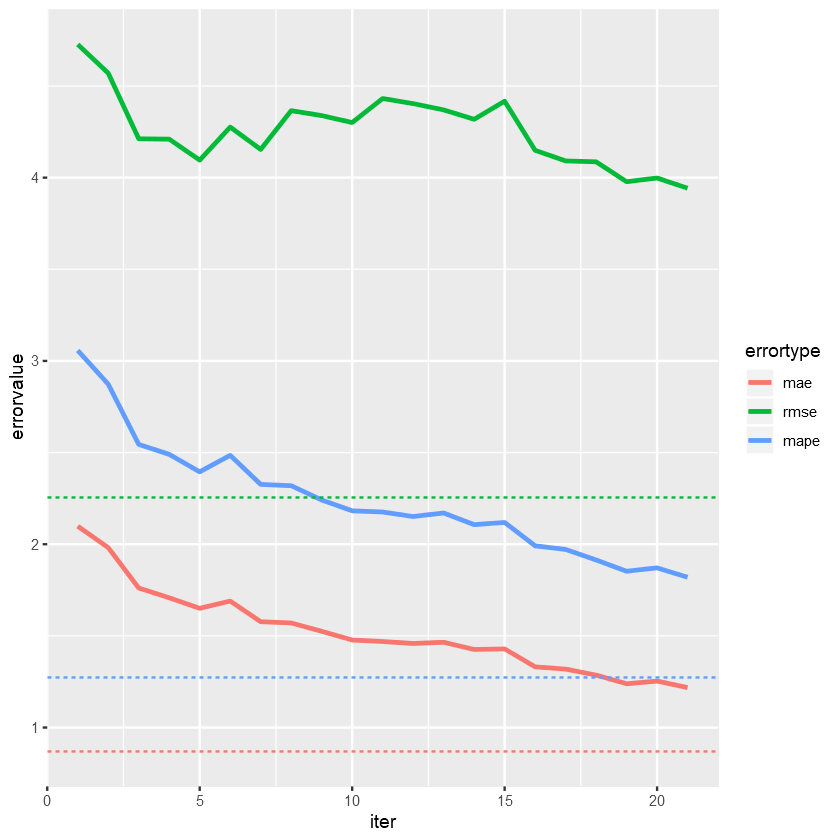

In [39]:
performance_molten_Rd <- melt(data = performance_table_Rd
                             , id.vars = 'iter')
setnames(performance_molten_Rd, c("variable","value"),c("errortype","errorvalue"))
p_Rd = ggplot(performance_molten_Rd, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
          geom_line(lwd=1) +
          geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed")

p_Rd

## Final Visualization

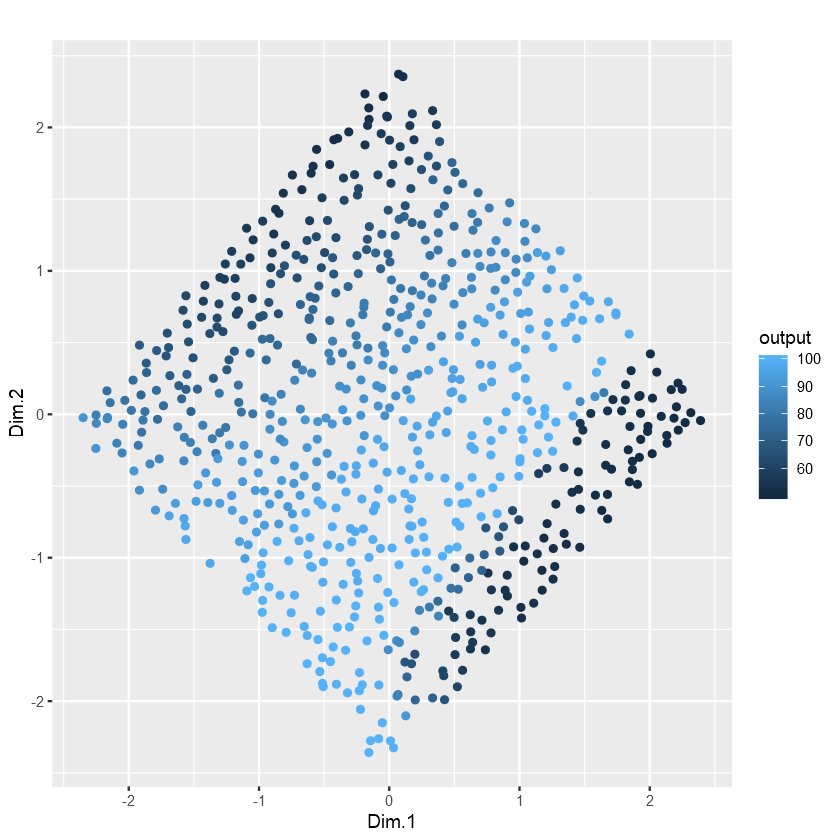

In [40]:
pca_final_Rd_training_set <- princomp(FinalTrainData_Rd[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

pca_final_Rd_training_set_components <- get_pca_ind(pca_final_Rd_training_set)
pca_final_Rd_training_set_components <-cbind(pca_final_Rd_training_set_components$coord[,1:2],FinalTrainData_Rd[,.SD, .SDcols = c("output")])
p_final_Rd_training_set <- ggplot(data = pca_final_Rd_training_set_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_final_Rd_training_set

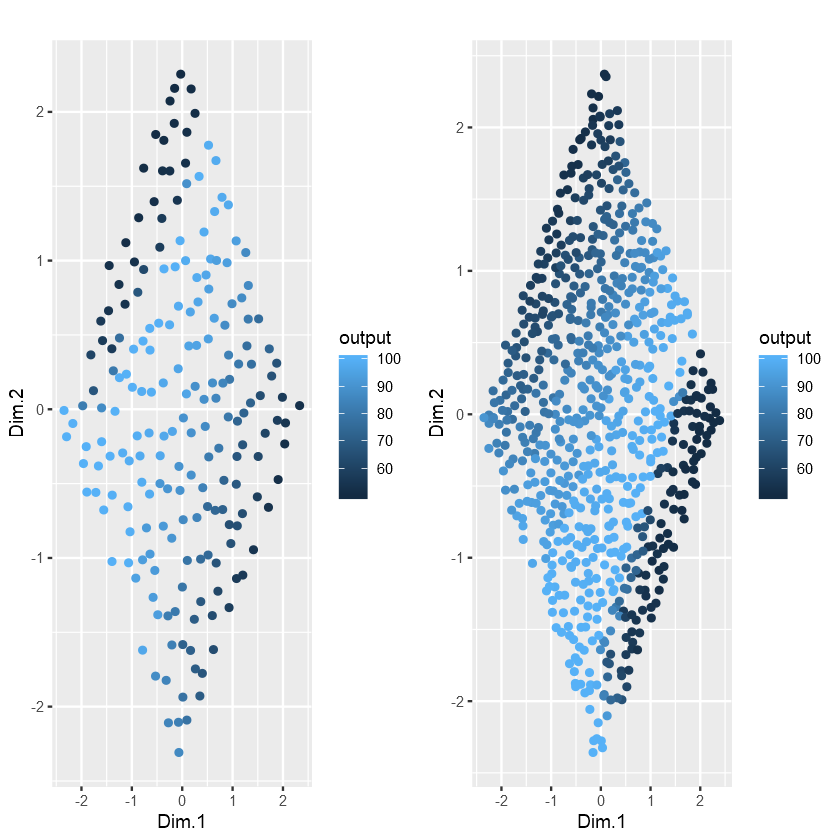

In [41]:
grid.arrange(p_training_set_Ad,p_final_Rd_training_set, ncol=2)

# Adaptive Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [42]:
training_set_Ad = copy(adaptive_initial_data)
unlabeled_pool =copy(data_candidates)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90  & `density` < 90],200)
#
#}

### Visualization

In [43]:
pca_training_set_Ad <- princomp(training_set_Ad[,-c("output")], cor = TRUE, scores = TRUE)

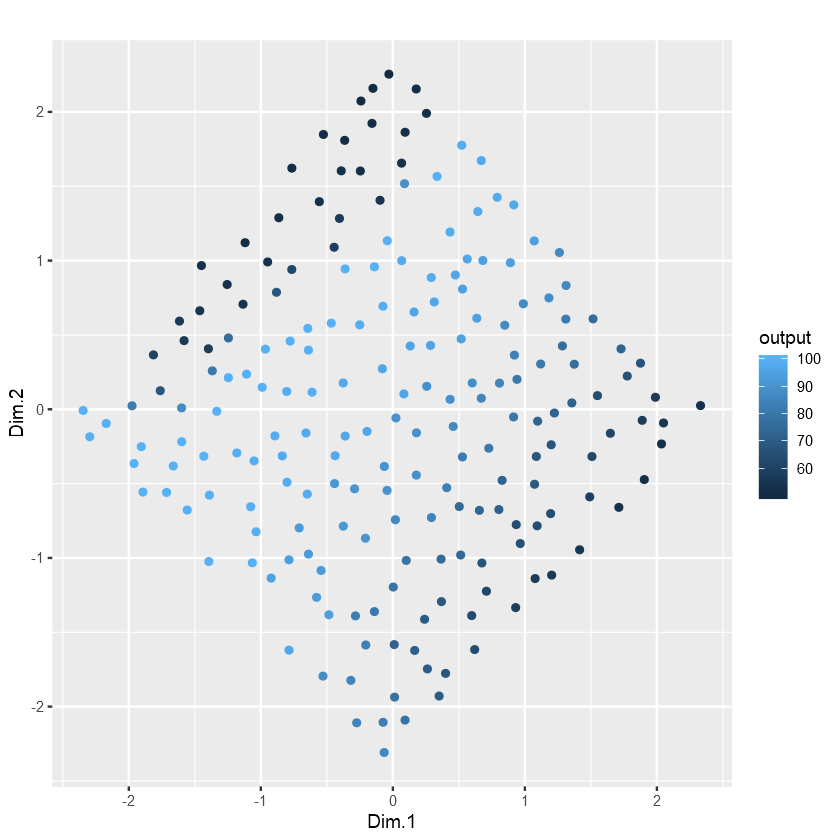

In [44]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_training_set_Ad_components <- get_pca_ind(pca_training_set_Ad)
pca_training_set_Ad_components <-cbind(pca_training_set_Ad_components$coord[,1:2],training_set_Ad[,c("output")])
p_training_set_Ad <- ggplot(data = pca_training_set_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_training_set_Ad

## Train & Test Metamodel

In [ ]:
# Decide on strategy:
#iteration_budget = 3

#h = 1 # specify how many variable will be eliminated in each elimination iteration

In [45]:
## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

In [46]:
set.seed(10)
print(paste0("section start time : ",Sys.time()))
iter = 1
while(iter <= iteration_budget){   
    print(iter)

    trainx = training_set_Ad[,.SD, .SDcols = feature_names]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
                    
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)

    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.    
    ## sample selection from unlabeled data select candidates
        unlabeled_set <- copy(unlabeled_pool)
        train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
        
        # eliminate candidates from the unlabeled pool
        unlabeled_pool = unlabeled_pool[-train_candidates$idx]
        rm(unlabeled_set)
        
        # run ABM to find outputs of train candidates
        print(paste0("ABM train_candidate run start time : ",Sys.time()))
        train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
        print(paste0("ABM train_candidate run end time : ",Sys.time()))
        
        train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
        
        # add labeled candidates to the train data
        training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
    }
    iter = iter + 1
}
print(paste0("section end time : ",Sys.time()))

[1] "section start time : 2020-01-09 07:50:25"
[1] 1
[1] "ABM train_candidate run start time : 2020-01-09 07:50:25"
[1] "ABM train_candidate run end time : 2020-01-09 07:51:31"
[1] 2
[1] "ABM train_candidate run start time : 2020-01-09 07:51:31"
[1] "ABM train_candidate run end time : 2020-01-09 07:52:11"
[1] 3
[1] "ABM train_candidate run start time : 2020-01-09 07:52:11"
[1] "ABM train_candidate run end time : 2020-01-09 07:53:23"
[1] 4
[1] "ABM train_candidate run start time : 2020-01-09 07:53:23"
[1] "ABM train_candidate run end time : 2020-01-09 07:53:56"
[1] 5
[1] "ABM train_candidate run start time : 2020-01-09 07:53:56"
[1] "ABM train_candidate run end time : 2020-01-09 07:55:01"
[1] 6
[1] "ABM train_candidate run start time : 2020-01-09 07:55:01"
[1] "ABM train_candidate run end time : 2020-01-09 07:55:36"
[1] 7
[1] "ABM train_candidate run start time : 2020-01-09 07:55:36"
[1] "ABM train_candidate run end time : 2020-01-09 07:56:24"
[1] 8
[1] "ABM train_candidate run start ti

started : 2020-01-09 07:50:25 // ended : 2020-01-09 08:05:12 // 3 nofrep * 25 sample * 20 selection iter = 1500 runs

In [47]:
# Final records
FinalTrainData_Ad = copy(training_set_Ad)
performance_table_Ad = copy(performance_table)
train_candidates_table_Ad  = copy(train_candidates_table)
predictedLabels_table_Ad = copy(predictedLabels_table)
obb_error_Ad = copy(obb_error)

In [48]:
fwrite(FinalTrainData_Ad,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/FinalTrainData_Ad_BasicCode_Oneshot_120tree_",Sys.Date(),".csv") )
fwrite(performance_table_Ad,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/performance_table_Ad_BasicCode_Oneshot_120tree_",Sys.Date(),".csv") )
fwrite(train_candidates_table_Ad,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/train_candidates_table_Ad_BasicCode_Oneshot_120tree_",Sys.Date(),".csv") )
fwrite(predictedLabels_table_Ad,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/predictedLabels_table_Ad_BasicCode_Oneshot_120tree_",Sys.Date(),".csv") )
fwrite(obb_error_Ad,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/obb_error_Ad_BasicCode_Oneshot_120tree_",Sys.Date(),".csv") )

In [49]:
nrow(FinalTrainData_Ad)
performance_table_Ad
train_candidates_table_Ad
head(predictedLabels_table_Ad)
obb_error_Ad

[1] 700

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,2.098431,4.726630,3.057153
2,1.859375,4.093794,2.644220
3,1.620871,4.108958,2.385732
4,1.488399,3.750737,2.198436
5,1.427667,3.729329,2.122453
6,1.403866,3.746627,2.092942
7,1.353648,3.741495,2.024827
8,1.325721,3.712259,1.974942
9,1.233714,3.602602,1.840287


density,%-similar-wanted,idx,output,iter
<dbl>,<dbl>,<int>,<dbl>,<dbl>
79.18638,74.59114,511,80.49105,1
52.51502,74.99535,136,99.78008,1
66.32434,74.85613,195,99.69076,1
17.79868,75.83541,240,99.21569,1
70.47861,76.76088,60,56.37154,1
77.59878,77.15022,347,53.75866,1
38.04839,74.89497,270,99.77792,1
20.37012,75.14078,525,89.08438,1
66.09709,77.64091,576,56.00802,1


density,%-similar-wanted,output,pred_output_1,RMSE_1,pred_output_2,RMSE_2,pred_output_3,RMSE_3,pred_output_4,...,pred_output_17,RMSE_17,pred_output_18,RMSE_18,pred_output_19,RMSE_19,pred_output_20,RMSE_20,pred_output_21,RMSE_21
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39.27182,36.46039,86.97693,85.09648,1.88044819,85.08702,1.88990963,85.35318,1.62374792,87.29795,...,86.10360,0.87332991,86.24232,0.73460158,86.13812,0.83880613,86.16466,0.81226878,86.09525,0.88167326
28.12210,68.05564,99.86504,99.85598,0.00906429,99.87589,0.01085049,99.88775,0.02270882,99.85919,...,99.85092,0.01411977,99.89878,0.03373267,99.89524,0.03019831,99.90165,0.03660414,99.88404,0.01899542
75.80979,17.80044,57.77487,58.07941,0.30453968,58.06844,0.29357218,58.07288,0.29801479,58.01455,...,58.26936,0.49449434,58.31443,0.53955758,58.20851,0.43364434,58.11287,0.33800311,58.26916,0.49429048
57.76825,28.64345,73.81257,72.92002,0.89254967,72.81823,0.99433760,72.56356,1.24900471,72.94710,...,72.09488,1.71768664,72.32781,1.48475839,72.24309,1.56948021,72.19036,1.62220527,72.27469,1.53787091
18.53175,48.03778,93.79242,94.06373,0.27130985,94.10400,0.31158053,94.27468,0.48225806,94.59044,...,94.46940,0.67698362,94.51822,0.72580294,94.55704,0.76462251,94.50067,0.70825353,94.61872,0.82629938
80.09701,42.18455,82.70191,85.22908,2.52716574,85.22995,2.52803980,85.37950,2.67758893,85.30000,...,82.97070,0.26878467,83.07368,0.37176974,83.15700,0.45509087,83.19541,0.49349669,83.10918,0.40726512


iter,obb_error
<dbl>,<dbl>
1,15.080129
2,14.570913
3,10.507075
4,10.546756
5,8.803361
6,8.018189
7,7.473081
8,6.942357
9,6.331387


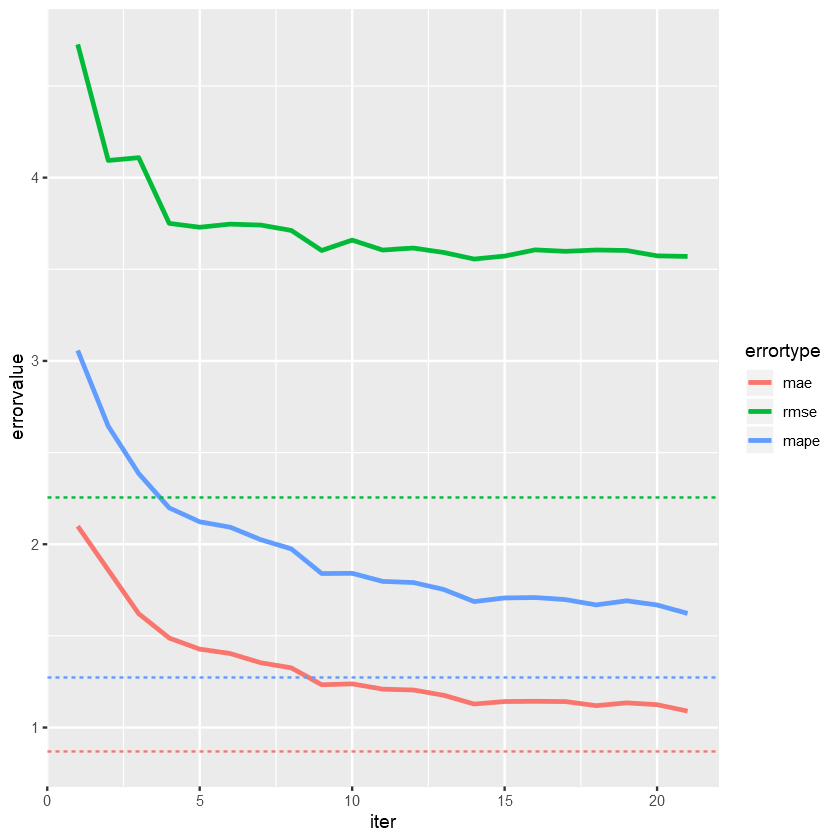

In [50]:
performance_molten_Ad <- melt(data = performance_table_Ad
                             , id.vars = 'iter')
setnames(performance_molten_Ad, c("variable","value"),c("errortype","errorvalue"))
p_Ad = ggplot(performance_molten_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1)+
          geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed")

p_Ad

## Final Visualization

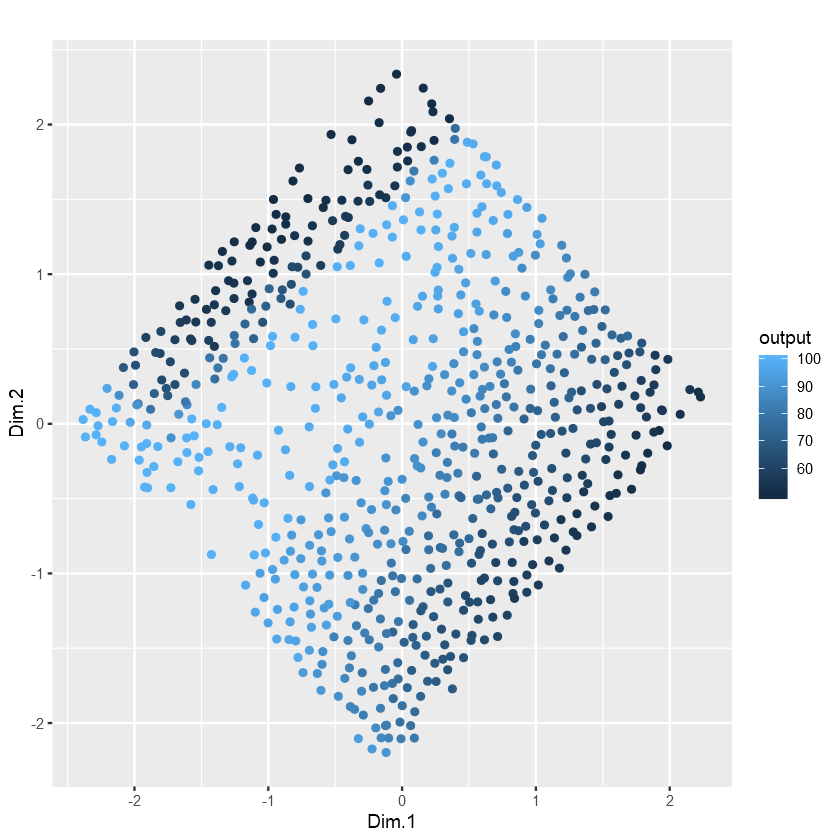

In [51]:
pca_final_Ad_training_set <- princomp(FinalTrainData_Ad[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

pca_final_Ad_training_set_components <- get_pca_ind(pca_final_Ad_training_set)
pca_final_Ad_training_set_components <-cbind(pca_final_Ad_training_set_components$coord[,1:2],FinalTrainData_Ad[,.SD, .SDcols = c("output")])
p_final_Ad_training_set <- ggplot(data = pca_final_Ad_training_set_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_final_Ad_training_set

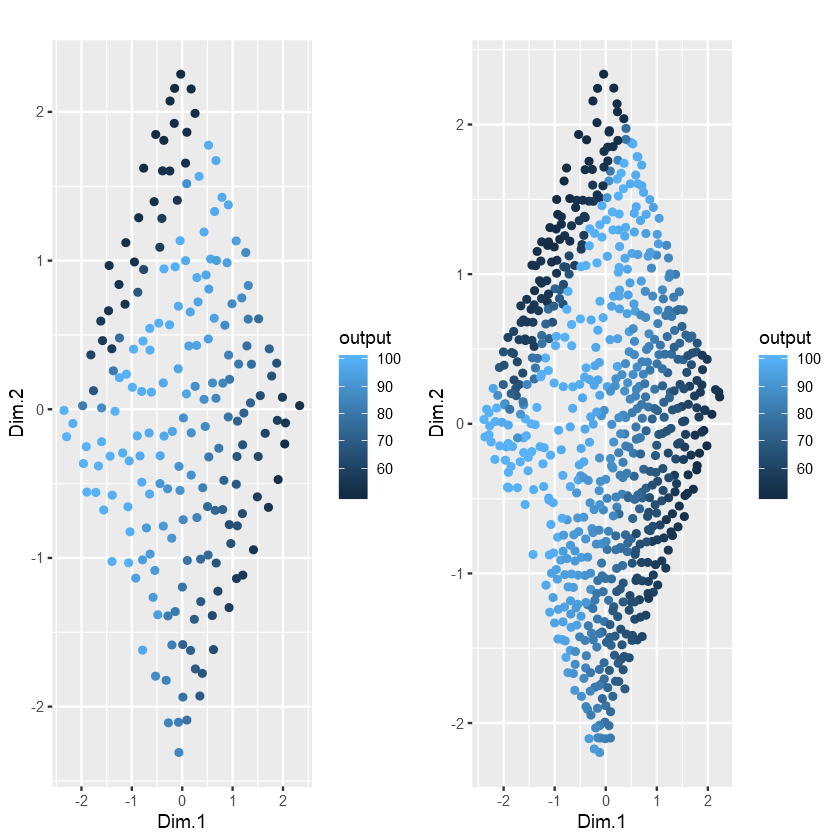

In [52]:
grid.arrange(p_training_set_Ad,p_final_Ad_training_set, ncol=2)

# 3 scenarios

In [53]:
nrow(FinalTrainData_Ad)
nrow(training_set)
nrow(FinalTrainData_Rd)

[1] 700

[1] 700

[1] 700

In [54]:
oneshot_model = randomForest( x = training_set[, -c("output")]
                             ,y = training_set$output
                             , importance = TRUE,ntree = ntree, mtry = mtry)
random_model = randomForest( x = FinalTrainData_Rd[,.SD, .SDcols = feature_names]
                              ,y = FinalTrainData_Rd$output
                              ,importance = TRUE,ntree = ntree, mtry = mtry)
adaptive_model = randomForest( x = FinalTrainData_Ad[,.SD, .SDcols = feature_names]
                              ,y = FinalTrainData_Ad$output
                              ,importance = TRUE,ntree = ntree, mtry = mtry)



In [55]:
oneshot_model
random_model
adaptive_model


Call:
 randomForest(x = training_set[, -c("output")], y = training_set$output,      ntree = ntree, mtry = mtry, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 120
No. of variables tried at each split: 2

          Mean of squared residuals: 9.067203
                    % Var explained: 96.99


Call:
 randomForest(x = FinalTrainData_Rd[, .SD, .SDcols = feature_names],      y = FinalTrainData_Rd$output, ntree = ntree, mtry = mtry,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 120
No. of variables tried at each split: 2

          Mean of squared residuals: 2.905949
                    % Var explained: 99.02


Call:
 randomForest(x = FinalTrainData_Ad[, .SD, .SDcols = feature_names],      y = FinalTrainData_Ad$output, ntree = ntree, mtry = mtry,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 120
No. of variables tried at each split: 2

          Mean of squared residuals: 4.553186
                    % Var explained: 98.3

In [56]:
pred_oneshot <- predict(oneshot_model, test_set)
pred_oneshot <- cbind(test_set,pred_oneshot)

pred_rd <- predict(random_model, test_set)
pred_rd <- cbind(test_set,pred_rd)

pred_ad <- predict(adaptive_model, test_set)
pred_ad <- cbind(test_set,pred_ad)


In [57]:
pred_oneshot[,RMSE := mapply(function(x,y) rmse_func(x,y),output,pred_oneshot)]
pred_rd[,RMSE := mapply(function(x,y) rmse_func(x,y),output,pred_rd)]
pred_ad[,RMSE := mapply(function(x,y) rmse_func(x,y),output,pred_ad)]                                                          

In [58]:
rmse(pred_oneshot$output,pred_oneshot$pred_oneshot)
rmse(pred_rd$output,pred_rd$pred_rd)
rmse(pred_ad$output,pred_ad$pred_ad)

[1] 2.233845

[1] 3.965342

[1] 3.603769

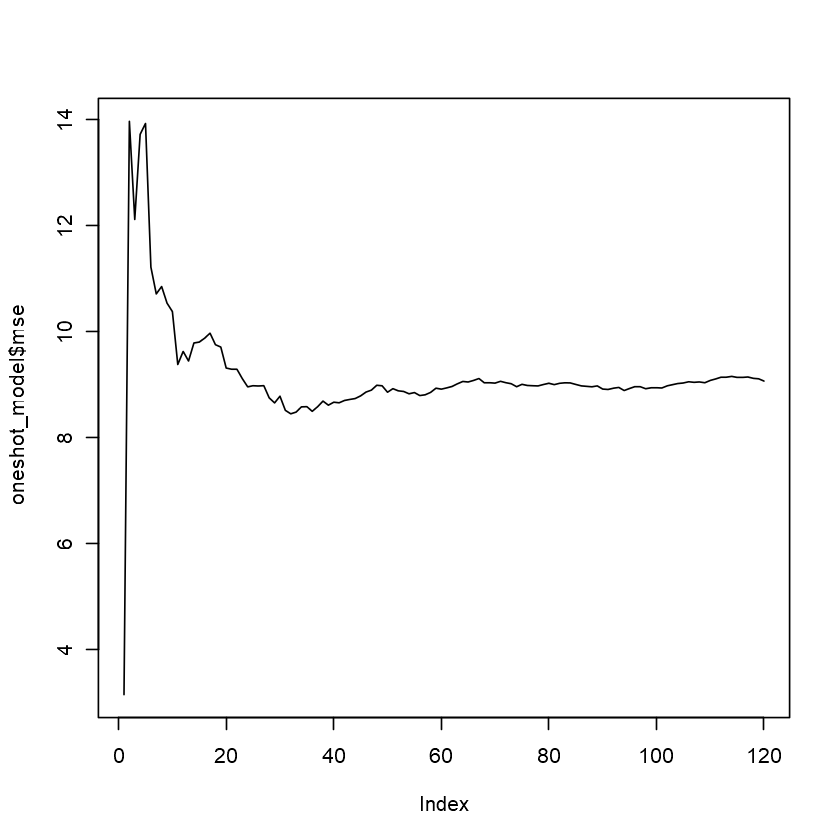

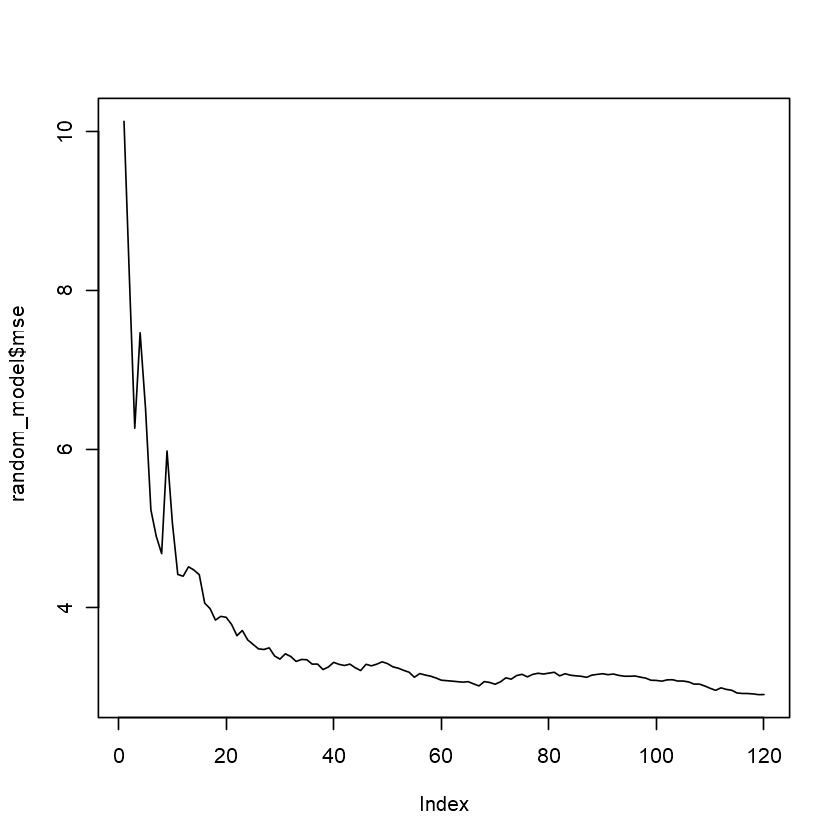

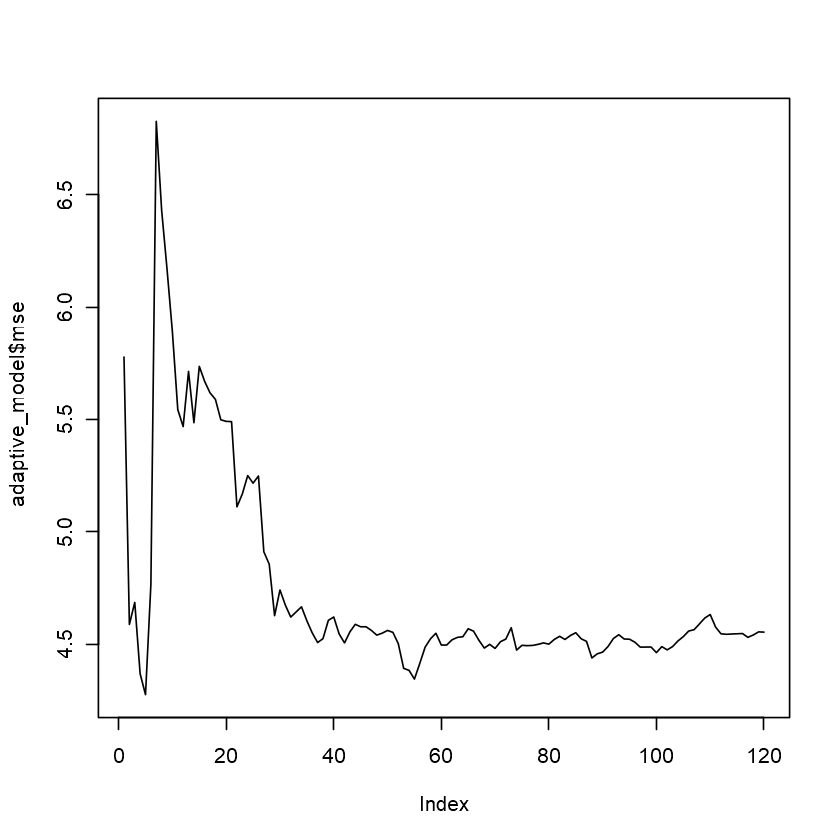

In [59]:
plot(oneshot_model$mse, type="l")
plot(random_model$mse, type="l")
plot(adaptive_model$mse, type="l")

# Random Sampling vs Uncertainty Sampling

## Final Data Comparison

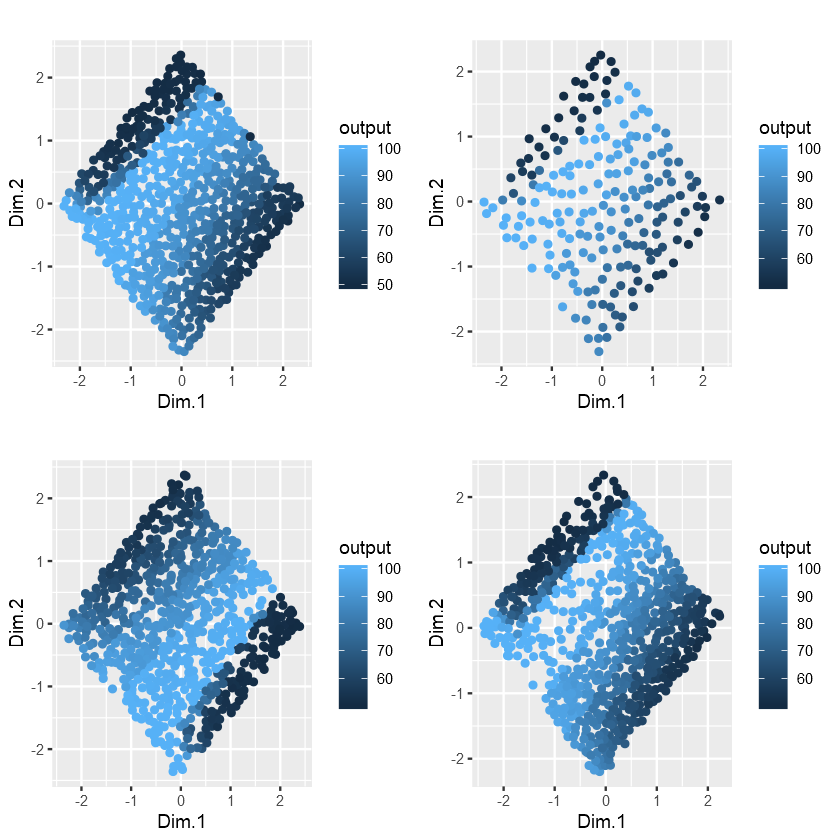

In [60]:
grid.arrange(p_training_set, p_training_set_Ad,p_final_Rd_training_set,p_final_Ad_training_set,nrow=2, ncol=2)

## Performance Comparison

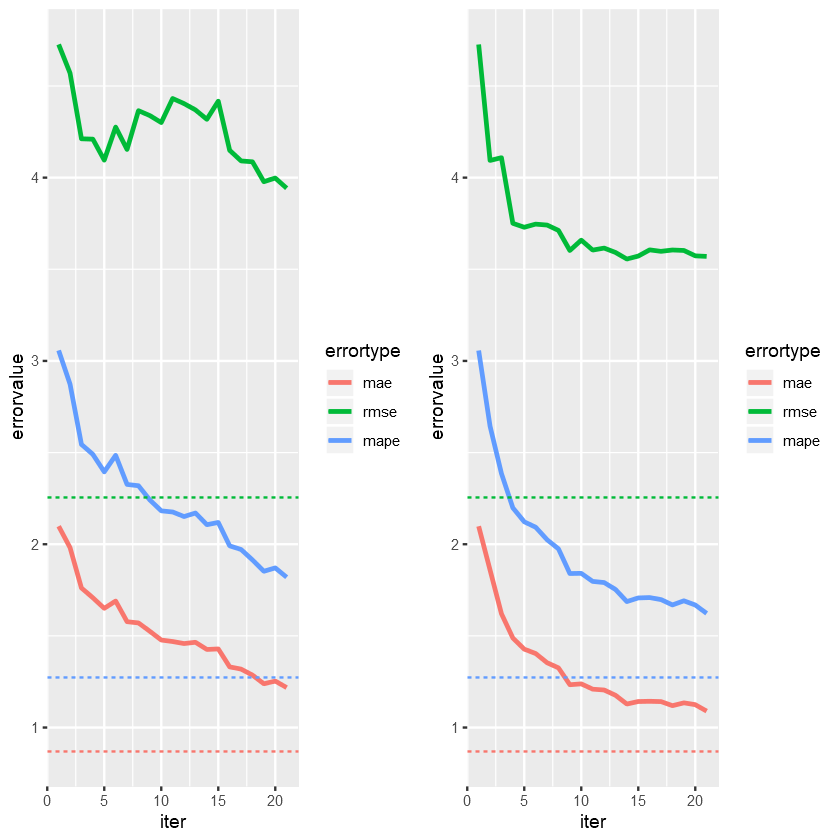

In [61]:
grid.arrange(p_Rd, p_Ad, ncol=2)

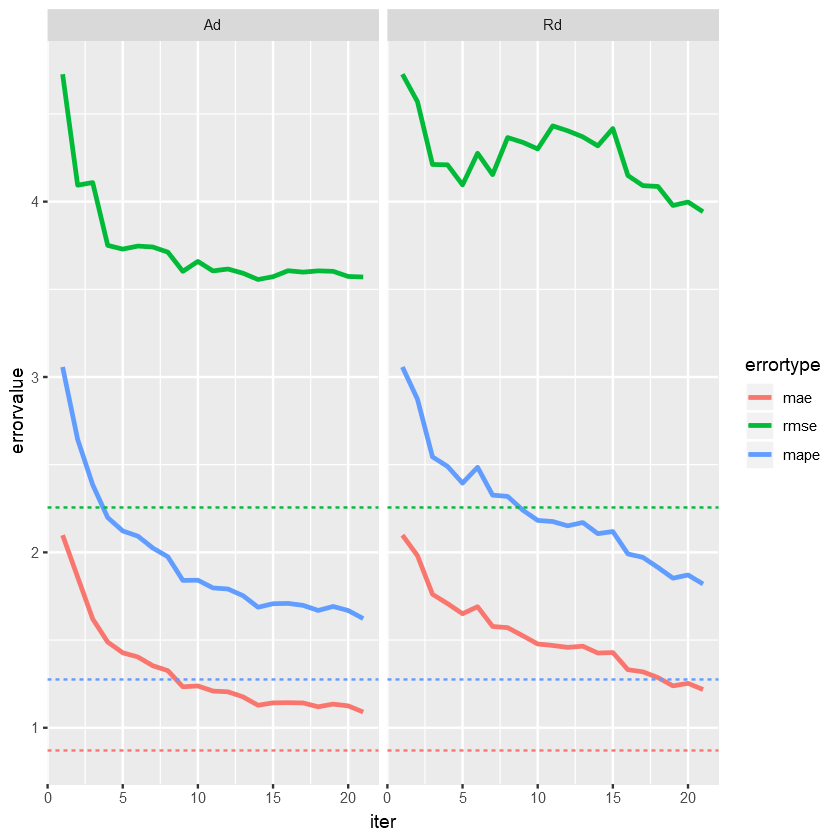

In [62]:
performance_Rd_vs_Ad = rbind(performance_molten_Rd[,.(iter,errortype,errorvalue, type = "Rd")],performance_molten_Ad[,.(iter,errortype,errorvalue, type = "Ad")])
p_Rd_vs_Ad = ggplot(performance_Rd_vs_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_wrap(~type)
p_Rd_vs_Ad

In [ ]:
ggplotly(p_Rd_vs_Ad)

In [63]:
comp = performance_Rd_vs_Ad[iter == 20 & errortype =="rmse"]
comp[, oneshot_error := performance_molten_oneshot[errortype =="rmse"]$errorvalue]      
comp[,diff := (errorvalue - oneshot_error) ]
comp[,diff_perc := (errorvalue - oneshot_error) / oneshot_error ]
comp

iter,errortype,errorvalue,type,oneshot_error,diff,diff_perc
<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
20,rmse,3.997953,Rd,2.257466,1.740487,0.7709913
20,rmse,3.573437,Ad,2.257466,1.315971,0.5829418


# Adaptive Sampling & Feature Elimination 

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [ ]:
training_set_Ad = copy(adaptive_initial_data)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90  & `density` < 90],200)
#
#}

### Visualization

In [ ]:
pca_training_set_Ad <- princomp(training_set_Ad[,-c("output")], cor = TRUE, scores = TRUE)

In [ ]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_training_set_Ad_components <- get_pca_ind(pca_training_set_Ad)
pca_training_set_Ad_components <-cbind(pca_training_set_Ad_components$coord[,1:2],training_set_Ad[,c("output")])
p_training_set_Ad <- ggplot(data = pca_training_set_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_training_set_Ad

## Train and Test Metamodel

In [ ]:
# Decide on strategy:
sample_selection_iteration_order = c(1:19)
feature_elimination_iteration_order = c(19)
#iteration_budget = 3 # should be > max(max(sample_selection_iteration_order),max(feature_elimination_iteration_order))

#h = 1 # specify how many variable will be eliminated in each elimination iteration

In [ ]:
feature_names

In [ ]:
## initialize record tables Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae = numeric(), rmse = numeric(), mape = numeric())

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

# Record iteration history
iteration_history = data.table(iter_no = numeric(), IsFeatureEliminated = logical(), IsDataSelected = logical())

## initialize variables
# keep test set undistorted
predictedLabels_table = copy(test_set)

# specify variables(columns) to be used initialize
columns_left = feature_names
total_numof_eliminated_vars <- 0

In [ ]:
set.seed(10)
print(paste0("section start time : ",Sys.time()))
iter = 1
while (iter <= iteration_budget) {
    
    trainx = training_set_Ad[, .SD, .SDcols = columns_left]
    trainy = training_set_Ad$output
    
    # Train the model
    model_Sub <- randomForest(x = trainx, y = trainy, importance = TRUE, ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_", iter), model_Sub)
    
    if (length(columns_left) == length(feature_names)) {
        ranked_features = get_variable_importance(model_Sub)
    }
    # Keep training set error records
    obb_error = rbind(obb_error, data.table(iter, obb_error_func(model_Sub)), use.names = FALSE)
    
    # Test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub, test_set, error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub, c("pred_output", error_type), c(paste0("pred_output_", iter), paste0(error_type, "_", iter)))
    predictedLabels_table = cbind(predictedLabels_table, predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_", iter), paste0(error_type, "_", iter))])
    
    # Keep test set error records
    performance_table = rbind(performance_table, data.table(iter, test_predictions_Sub[[2]]), use.names = FALSE)
    
    # update iteration_history
    iteration_history = rbind(iteration_history, data.table(iter, 0, 0), use.names = FALSE)
    
    if(iter != iteration_budget){ # below efforts are unnecessary when the budget is reached.
          if (iter %in% sample_selection_iteration_order) {
              ## sample selection from unlabeled data select candidates
              unlabeled_set <- copy(unlabeled_pool)
              train_candidates = sample_selection(selected_ins, unlabeled_set, model_Sub)
              
              # eliminate candidates from the unlabeled pool
              unlabeled_pool = unlabeled_pool[-train_candidates$idx]
              rm(unlabeled_set)
              
              # run ABM to find outputs of train candidates
              print(paste0("ABM train_candidate run start time : ",Sys.time()))
              train_candidates = run_ABM(nofrep, selected_ins, train_candidates)
              print(paste0("ABM train_candidate run end time : ",Sys.time()))
              
              train_candidates_table = rbind(train_candidates_table, data.table(train_candidates,iter = iter))
              
              # add labeled candidates to the train data
              training_set_Ad = rbind(training_set_Ad, train_candidates[, -c("idx")])
              
              # update iteration_history
               iteration_history[iter]$IsDataSelected= 1
          }
          if (iter %in% feature_elimination_iteration_order) {
              ## feature elimination apply feature elimination
              feature_elimination_result = feature_elimination(h, total_numof_eliminated_vars, ranked_features)
              
              columns_left = feature_elimination_result[[1]]  # 
              eliminated_columns = feature_elimination_result[[4]]  #   not necessary
              total_numof_eliminated_vars = as.numeric(feature_elimination_result[2])
              numof_eliminated_vars = as.numeric(feature_elimination_result[3])  #   not necessary 
              
              # update iteration_history
              iteration_history[iter]$IsFeatureEliminated= 1
          }
    }
iter = iter + 1  
}
print(paste0("section end time : ",Sys.time()))

950 runs: "section start time : 2020-01-08 21:46:52" // "section end time : 2020-01-08 22:02:30"

In [ ]:
#performance_error_table = performance_table[,.SD,.SDcols = c("iter",tolower(error_type))]
#setnames(performance_error_table,c("iter","error"))
#performance_error_table[, lag_error := shift(error,1,type = "lag")]
#performance_error_table
performance_error_table[.N]

In [ ]:
columns_left

In [ ]:
# Final records
FinalTrainData_AdFe = copy(training_set_Ad)
performance_table_AdFe = copy(performance_table)
train_candidates_table_AdFe  = copy(train_candidates_table)
predictedLabels_table_AdFe = copy(predictedLabels_table)
obb_error_AdFe = copy(obb_error)

In [ ]:
#fwrite(FinalTrainData_AdFe,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/FinalTrainData_AdFe_BasicCode_Oneshot_",Sys.Date(),".csv") )
#fwrite(performance_table_AdFe,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/performance_table_AdFe_BasicCode_Oneshot_",Sys.Date(),".csv") )
#fwrite(train_candidates_table_AdFe,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/train_candidates_table_AdFe_BasicCode_Oneshot_",Sys.Date(),".csv") )
#fwrite(predictedLabels_table_AdFe,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/predictedLabels_table_AdFe_BasicCode_Oneshot_",Sys.Date(),".csv") )
#fwrite(obb_error_AdFe,paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/obb_error_AdFe_BasicCode_Oneshot_",Sys.Date(),".csv") )

In [ ]:
nrow(FinalTrainData_AdFe)
performance_table_AdFe
train_candidates_table_AdFe
head(predictedLabels_table_AdFe)
obb_error_AdFe

In [ ]:
iteration_history

In [ ]:
performance_molten_AdFe <- melt(data = performance_table_AdFe
                             , id.vars = 'iter')
setnames(performance_molten_AdFe, c("variable","value"),c("errortype","errorvalue"))
p_AdFe = ggplot(performance_molten_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
            geom_vline(xintercept = iteration_history[IsDataSelected==1]$iter_no + 1, linetype = "dotdash",color = "yellow")
p_AdFe

# Adaptive Sampling with/without Feature Elimination

In [ ]:
performance_Ad_vs_AdFe = rbind(performance_molten_Ad[,.(iter,errortype,errorvalue, type = "Ad")], performance_molten_AdFe[,.(iter,errortype,errorvalue, type = "AdFe")])
p_Ad_vs_AdFe = ggplot(performance_Ad_vs_AdFe, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1) +
            geom_vline(xintercept = iteration_history[IsFeatureEliminated==1]$iter_no + 1, linetype = "dashed") +
            geom_hline(data = performance_molten_oneshot, aes(yintercept = errorvalue, group=errortype, col=errortype),stat = "hline", linetype = "dashed") +
            facet_wrap(~type)
p_Ad_vs_AdFe

In [ ]:
ggplotly(p_Ad_vs_AdFe)

In [ ]:
#head(train_candidates_table_AdFe)
#head(train_candidates_table_Ad)

In [ ]:
#varImpPlot(model_Ad)

# Quit NL

In [ ]:
NLQuit(nl.obj = nl.model)
#NLQuit(all=FALSE)